In [2]:
!pip install vk_api
!pip install networkx
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.5 MB/s eta 0:00:00


In [30]:
import vk_api
import networkx as nx
import plotly.graph_objs as go

# Получаем токен VK API
token = 'ТУТ ТОКЕН'  
vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()


def get_friends(user_id):
    try:
        friends = vk.friends.get(user_id=user_id, fields='nickname')
        return friends['items']
    except vk_api.exceptions.VkApiError as e:
        print(f"Error getting friends for user {user_id}: {e}")
        return []


def get_user_name(user_id):
    try:
        user = vk.users.get(user_ids=user_id)[0]
        return user['first_name'] + ' ' + user['last_name']
    except vk_api.exceptions.VkApiError as e:
        print(f"Error getting user info for {user_id}: {e}")
        return str(user_id) 


target_user_ids = [205762499, 637593527, 101098087, 62269831] 


friendships = []


for user_id in target_user_ids:
    friends = get_friends(user_id)
    for friend in friends:
        friendships.append((user_id, friend['id']))  


G = nx.Graph()
G.add_edges_from(friendships)


user_names = {node: get_user_name(node) for node in G.nodes()}


betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)


pos = nx.spring_layout(G, seed=42, k=0.15)


edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')


node_x = []
node_y = []
node_sizes = []
node_text = []
node_colors = []


for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_sizes=10  
    node_colors.append(betweenness[node])      
    node_text.append(f"{user_names[node]}<br>"
                     f"BC: {betweenness[node]:.4f}<br>"
                     f"CC: {closeness[node]:.4f}<br>"
                     f"EV: {eigenvector[node]:.4f}")  


node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,  
    marker=dict(
        showscale=True,
        colorscale='Blues',
        color=node_colors,  
        size=10,  
        colorbar=dict(
            thickness=15,
            title='Betweenness Centrality',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))


fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Граф друзей (с центральностями по посредничеству, близости и собственного вектора)',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    annotations=[dict(
                        text="Оценка центральности для каждого пользователя отображается при наведении",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002
                    )],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False))
               )

fig.show()


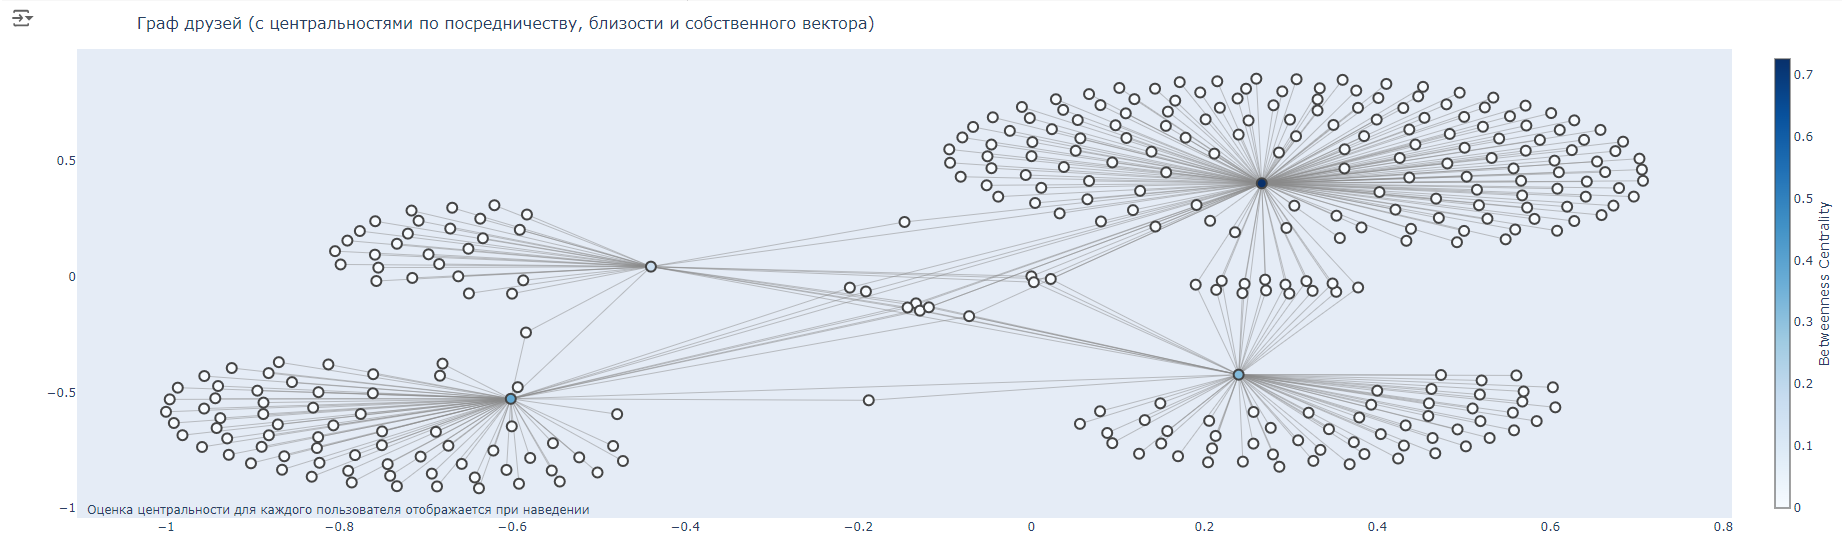